# Traffic Sign Detection Solution
Source: Tobias Augspurger for Udacity ND

## Load Data and your Dependencies

Load the German Traffic Sign Dataset into train, valid and test data.

In [1]:
import cv2
import numpy as np
import pandas as pd
import random
import pickle
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

training_file = "imagesDL/train.p"
validation_file="imagesDL/valid.p"
testing_file = "imagesDL/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']



# Show Shape and Dimensions

In [2]:
print("Image Shape: {}".format(X_train[0].shape))
print("Number Training Images", X_train[0].shape)
print("Number of Validation Images", X_validation[0].shape)


Image Shape: (32, 32, 3)
Number Training Images (32, 32, 3)
Number of Validation Images (32, 32, 3)


## Visualize Data

Show 20 Random Pictures from the Dataset

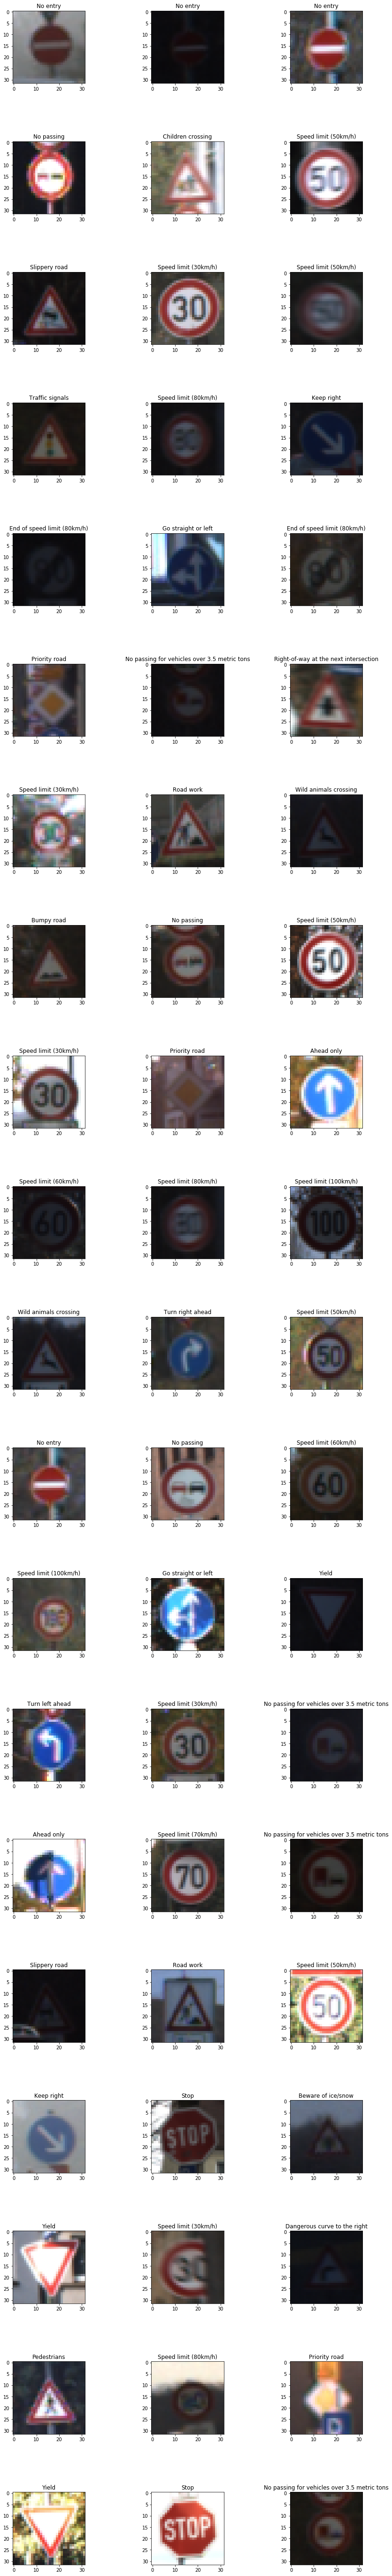

In [23]:
classes = pd.read_csv("signnames.csv")
classes.set_index("ClassId")
plt.figure(figsize=(15, 100))
pic_dis = 60
pic_p_raw = 3

for i in range(0,pic_dis):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    plt.subplot(pic_dis/pic_p_raw ,3,1+i)
    plt.imshow(image, cmap="gray")
    plt.subplots_adjust(hspace=0.8)
    plt.title(classes.at[y_train[index],'SignName'])
    
    
  

# Preprocess Data

Shuffle the training data and preprocess the features by normalization and reduction of the data to a single channel.

In [4]:
def preprocessing_feature(X):
    # Since Traffic Sign have colour Space for humans use that:
    # https://samarthbhargav.wordpress.com/2014/05/05/image-processing-with-python-rgb-to-grayscale-conversion/
    X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]
    
    # Magic Feature Scaling with the a 8 Bit Pixel value
    # https://en.wikipedia.org/wiki/Feature_scaling
    # Rescaling
    X = (X / 255.).astype(np.float32)
    
    #Single Greyscale Channel
    X = X.reshape(X.shape + (1,)) 
    return X
# Shuffle the Trainingsdata
X_train, y_train = shuffle(X_train, y_train)
#X_test = preprocessing_feature(X_test)
#X_train = preprocessing_feature(X_train)
X_train, y_train = shuffle(X_train, y_train)
# Generate a Random Split of the Traning Data for Validation
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20)

## Setup Your Hyperparamter and Design the DNN
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

In [5]:
EPOCHS = 30
BATCH_SIZE = 64
rate = 0.0001
# Dropout value indicates propapility to keep value
dropout1 = 1 
dropout2 = 0.90
dropout3 = 0.80
dropout4 = 0.70
dropout5 = 0.60

Define the Architecture of the DNN Model

In [6]:
def deepnn_model_2(x):
    # Define the Parameter for the normal distribution
    mu = 0
    sigma = 0.1
    
    # Get the start weights and biases for 6 Layers
    # 32 Pixel / 5 Windows -> No Padding
    layer1_weight = tf.Variable(tf.truncated_normal([5, 5, 1, 8],mean = mu,stddev=sigma))
    layer1_bias = tf.Variable(tf.zeros(8))
    layer2_weight = tf.Variable(tf.truncated_normal([5, 5, 8, 16],mean = mu,stddev=sigma))
    layer2_bias = tf.Variable(tf.zeros(16))
    
    insp_layer1_weight = tf.Variable(tf.truncated_normal([1, 1, 16, 16],mean = mu,stddev=sigma))
    insp_layer1_bias = tf.Variable(tf.zeros(16))
    insp_layer2_weight = tf.Variable(tf.truncated_normal([1, 1, 16, 16],mean = mu,stddev=sigma))
    insp_layer2_bias = tf.Variable(tf.zeros(16))
    insp_layer3_weight = tf.Variable(tf.truncated_normal([1, 1, 16, 80],mean = mu,stddev=sigma))
    insp_layer3_bias = tf.Variable(tf.zeros(80))
    
    
    flat_weight = tf.Variable(tf.truncated_normal([720, 200],mean = mu,stddev=sigma))
    bias_flat  =  tf.Variable(tf.zeros(200))
    flat_weight2 = tf.Variable(tf.truncated_normal([200, 84],mean = mu,stddev=sigma))
    bias_flat2 =   tf.Variable(tf.zeros(84))
    flat_weight3 = tf.Variable(tf.truncated_normal([84, 43],mean = mu,stddev=sigma))
    bias_flat3 =   tf.Variable(tf.zeros(43))
    
    
    #  -----  Layer 1  --- Convolution + Max Pooling
    x =   tf.nn.conv2d(x, layer1_weight, strides=[1, 1, 1, 1], padding='VALID')
    x =   tf.nn.bias_add(x, layer1_bias)
    # Use Relu Function for Activation
    x =   tf.nn.relu(x)
    x =   tf.nn.max_pool(x,ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1],padding='SAME')

    #  -----  Layer 2 ---- Convolution + Max Pooling
    x =   tf.nn.conv2d(x, layer2_weight, strides=[1, 1, 1, 1], padding='VALID')
    x =   tf.nn.bias_add(x, layer2_bias)
    x =   tf.nn.relu(x)
    x =   tf.nn.max_pool(x,ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1],padding='SAME')
        
     #-----  Layer 4 --- Inspection
    x =   tf.nn.conv2d(x, insp_layer1_weight, strides=[1, 1, 1, 1], padding='VALID')
    x =   tf.nn.bias_add(x, insp_layer1_bias)
    x =   tf.nn.relu(x)
    
    #-----  Layer 5 --- Inspection
    x =   tf.nn.conv2d(x, insp_layer2_weight, strides=[1, 1, 1, 1], padding='VALID')
    x =   tf.nn.bias_add(x, insp_layer2_bias)
    x =   tf.nn.relu(x)

    #-----  Layer 6 --- Inspection
    x =   tf.nn.conv2d(x, insp_layer3_weight, strides=[1, 1, 1, 1], padding='VALID')
    x =   tf.nn.bias_add(x, insp_layer3_bias)
    x =   tf.nn.relu(x)
    x = tf.nn.max_pool(x,ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1],padding='SAME')   #
    
    
    #  -----  Layer 7 ---- Flatten
    fc0   = flatten(x)
    fc1 = tf.add(tf.matmul(fc0, flat_weight),bias_flat)
    fc1 = tf.nn.relu(fc1)
    if(train):
        fc1 = tf.nn.dropout(fc1, dropout4)
    
    #  -----  Layer 8 ---- Fully Connected
    fc1 = tf.add(tf.matmul(fc1, flat_weight2),bias_flat2)
    fc1 = tf.nn.relu(fc1)
    if(train):
        fc1 = tf.nn.dropout(fc1, dropout5)
    
    #  -----  Layer 9 ---- Fully Connected
    fc1 = tf.add(tf.matmul(fc1, flat_weight3),bias_flat3)
    logits = tf.nn.relu(fc1)

    return logits

In [7]:
def deepnn_model_2(x):    
    #=============================================================================
    # hyper params
    mu = 0
    sigma = 0.1
    #keep_prob = 1
    
    #=============================================================================

    #=============================================================================
    # conv Layer 1
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)

    # pooling 1
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #=============================================================================

    #=============================================================================
    # conv Layer 2
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 12), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(12))
    conv2   = tf.nn.conv2d(conv1_pool, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    #=============================================================================
    
    #=============================================================================
    # layer 3: try inception-like layer 
    incept1_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 12, 12), mean = mu, stddev = sigma))
    incept1_b = tf.Variable(tf.zeros(12))
    incept1   = tf.nn.conv2d(conv2, incept1_W, strides=[1, 1, 1, 1], padding='SAME') + incept1_b
    incept1 = tf.nn.relu(incept1)
    
    incept2_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 12, 12), mean = mu, stddev = sigma))
    incept2_b = tf.Variable(tf.zeros(12))
    incept2   = tf.nn.conv2d(conv2, incept2_W, strides=[1, 1, 1, 1], padding='SAME') + incept2_b
    incept2 = tf.nn.relu(incept2)
    
    incept3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 12, 12), mean = mu, stddev = sigma))
    incept3_b = tf.Variable(tf.zeros(12))
    incept3   = tf.nn.conv2d(incept2, incept3_W, strides=[1, 1, 1, 1], padding='SAME') + incept3_b
    incept3 = tf.nn.relu(incept3)
    
    incept4 = tf.nn.max_pool(conv2, ksize=[1, 3, 3, 1], strides=[1, 1, 1, 1], padding='SAME')

    incept5_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 12, 12), mean = mu, stddev = sigma))
    incept5_b = tf.Variable(tf.zeros(12))
    incept5   = tf.nn.conv2d(incept4, incept5_W, strides=[1, 1, 1, 1], padding='SAME') + incept5_b
    incept5 = tf.nn.relu(incept5)
    
    incept6_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 12, 12), mean = mu, stddev = sigma))
    incept6_b = tf.Variable(tf.zeros(12))
    incept6   = tf.nn.conv2d(conv2, incept6_W, strides=[1, 1, 1, 1], padding='SAME') + incept6_b
    incept6 = tf.nn.relu(incept6)
    
    incept7_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 12, 12), mean = mu, stddev = sigma))
    incept7_b = tf.Variable(tf.zeros(12))
    incept7   = tf.nn.conv2d(incept6, incept7_W, strides=[1, 1, 1, 1], padding='SAME') + incept7_b
    incept7 = tf.nn.relu(incept7)
    
    #concat_layer = tf.concat(3,[incept1, incept3, incept5, incept7])
    concat_layer = tf.nn.relu(concat_layer)
    #=============================================================================
    
    #=============================================================================
    # layer 4: conv 2d
    conv3_W = tf.Variable(tf.truncated_normal(shape=(7, 7, 48, 60), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(60))
    conv3   = tf.nn.conv2d(concat_layer, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    conv3 = tf.nn.relu(conv3)
    
    # pooling 2
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #=============================================================================
      
    #=============================================================================
    # flatten out for fc layer 
    fc0   = flatten(conv3_pool)
    #=============================================================================
    
    #=============================================================================
    # fully connected layers with dropout
    # layer 5: fully connected with dropout, relu
    fc1_W = tf.Variable(tf.truncated_normal(shape=(240, 500), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(500))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 6: Fully Connected with dropout, relu
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(500, 250), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(250))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 7: Fully Connected with dropout, relu
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(250, 125), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(125))
    fc3    = tf.matmul(fc2, fc3_W) + fc3_b
    fc3    = tf.nn.relu(fc3)
    fc3    = tf.nn.dropout(fc3, keep_prob)

    # Layer 8: Fully Connected relu
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(125, 43), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc3, fc4_W) + fc4_b
    #=============================================================================

    # return logits before softmax and fc weights
    return logits

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [8]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
# Number of classes
one_hot_y = tf.one_hot(y, 43)



## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

In [9]:
logits = deepnn_model(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

NameError: name 'deepnn_model' is not defined

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [ ]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [ ]:
validation_progress = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        validation_progress.append(validation_accuracy)
        
    saver.save(sess, './lynet')
    print("Model saved")
    plt.plot(validation_progress)

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))